### Objective
This notebook aims to:
  - Analyze the sales time series: stationarity, seasonality, autocorelation  
  - Preprocess the dataset for modelling

In [13]:
import sys
import os
import missingno as msno
import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("../scripts"))) 
import load_data

# from data_infos import dataframeInfo
from clean import dataCleaning

from statsmodels.tsa.stattools import adfuller

In [14]:
logging.basicConfig(filename='../exploration_logfile.log', filemode='a',
                    encoding='utf-8', level=logging.DEBUG)

## Load data

In [15]:
data = load_data.load_data('../data/train_data.csv')
data = dataCleaning(data).cleanStateHoliday()
data = dataCleaning(data).dateformat('Date')

In [16]:
data.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2015-07-30,1,4,5020,546,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,2015-07-29,1,3,4782,523,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2015-07-28,1,2,5011,560,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,2015-07-27,1,1,6102,612,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## Quick stationarity checking

In [17]:
data.set_index('Date', inplace=True)

In [25]:
X = data['Sales'].values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=5801.525100, mean2=5746.112899
variance1=14744172.399597, variance2=14898126.160203


### The two means are approximatively the same: one can consider the sales as a stationary series.

### Let's check the decomposition in trend and seasonlity

<AxesSubplot:xlabel='Date'>

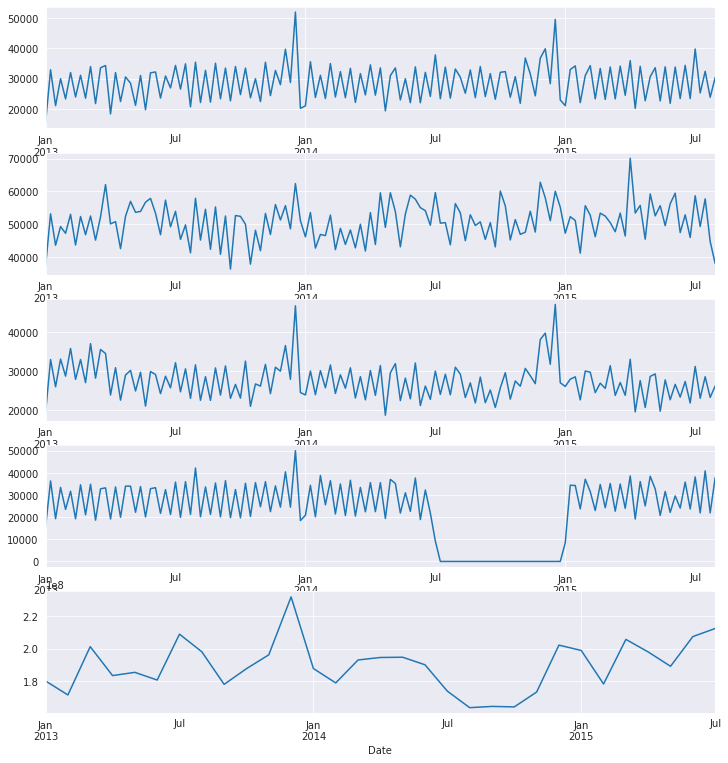

In [35]:
# preparation: input should be float type
data['Sales'] = data['Sales'] * 1.0

sales = data['Sales']
# store types
sales_a = data[data.Store == 2]['Sales']
sales_b = data[data.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = data[data.Store == 1]['Sales']
sales_d = data[data.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

sales.resample('M').sum().plot(ax = ax5)


In [36]:

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period = 30)

<AxesSubplot:xlabel='Date'>

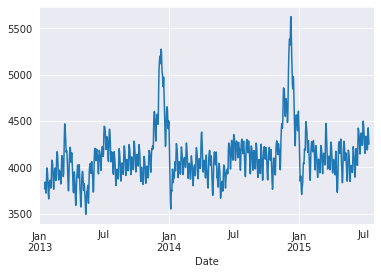

In [61]:
decomposition_a.trend.plot()

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition = seasonal_decompose(sales, model = 'additive', freq = 30)
decomposition.trend.plot(ax = ax1)

decomposition = seasonal_decompose(sales, model = 'additive', freq = 30)
decomposition.trend.plot(ax = ax2)

decomposition = seasonal_decompose(sales, model = 'additive', freq = 30)
decomposition.trend.plot(x = ax3)

decomposition = seasonal_decompose(sales, model = 'additive', freq = 30)
decomposition.trend.plot(ax = ax4)